In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Data Augmentation-XrayImg/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Data Augmentation-XrayImg


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/{cu_version}/{torch_version}/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/{cu_version}/{torch_version}/index.html
     |████████████████████████████████| 235kB 17.5MB/s 
     |████████████████████████████████| 194kB 50.2MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.2.7-cp37-cp37m-linux_x86_64.whl size=21764640 sha256=64a2c5e5e63d56869b29dc2f3a89f6ce32fc81c9031b31d6161711b898d8fe79
  Stored in directory: /root/.cache/pip/wheels/d9/eb/f8/766019b8f36d3a7b655618fc46d65bf52801906b30185a4624
Successfully built mmcv-full


In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -r requirements/build.txt
!pip install -v -e .


# 0. Import Libraies

In [3]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import json
import mmcv


# 1. Prepare Data

In [ ]:
#!unzip ../original.zip

In [ ]:
def get_anno(txt_path):
    annos=[]
    with open(txt_path) as f:
      for line in f.readlines():
        anno=line[:-1].split(" ")
        anno = [float(num) for num in anno]
        annos.append(anno[1:])
    return annos



def get_offset(annos,image): # for single image
  new_annos=[]
  for annotation in annos:
    bbox = [annotation[0] * image.shape[1], annotation[1] * image.shape[0], 
            annotation[2] * image.shape[1], annotation[3] * image.shape[0]]
    new_annos.append(bbox)
  return new_annos


def get_path(data_path):
  img_paths = glob.glob(os.path.join(data_path,"*.png"))
  dic={}
  for img_path in img_paths:
    txt_path = img_path.replace('.png','.txt')
    dic[img_path]=get_anno(txt_path)
  return dic



In [ ]:
# Predict label: [0 cx cy w h]
def my_draw(img_path,anno):
  image=cv2.imread(img_path)
  print(image.shape)
  bboxs=get_offset(anno,image)
  for bbox in bboxs:
    cv2.rectangle(image, (int(bbox[0] - bbox[2] / 2), int(bbox[1] - bbox[3] / 2)), (int(bbox[0] + bbox[2] / 2), int(bbox[1] + bbox[3] / 2)), (225, 0, 0), 2)
  plt.figure(figsize = (10, 10))
  plt.imshow(image)

def read_json(path):
  with open(path,'r') as f:
    data = json.load(f)
  return data

def write_json(dic,path):
  with open(path,'w') as f:
    json.dump(dic,f,indent=4)



In [ ]:
data_train_path = '../original/dataDetect_train'
dic_train=get_path(data_train_path)
data_test_path = '../original/dataDetect_test'
dic_test=get_path(data_test_path)

In [ ]:
write_json(dic_train,'../train_data.json')
write_json(dic_test,'../test_data.json')

(512, 161, 3)


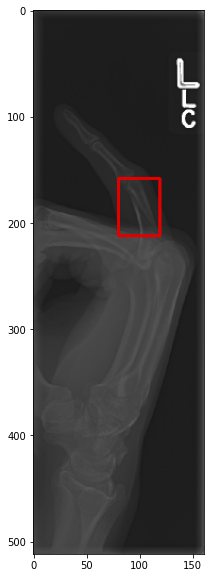

In [ ]:
test_dic=read_json('../test_data.json')
item=next(iter(test_dic.items()))
my_draw(item[0],item[1])

# 1. Convert data to COCO format

In [ ]:

def convert_coco(path,out_file):
  dic=read_json(path)
  coco_dic={"images": [], "annotations": [], "categories": []}

  for i,(k,v) in enumerate(dic.items()):
    img=mmcv.imread(k)
    image = {
      "file_name": k.split('/')[-1],
      "height": img.shape[0], # height of img
      "width": img.shape[1], # width of img
      "id": i,
    }
    coco_dic['images'].append(image)

    bbxs=get_offset(v,img)  # [ [x_c,y_c,width,height] , [ bbx2 ], [bbx3]  ]
    for j,bbx in enumerate(bbxs):
      data_bbx = {
          'image_id':i,
          'id':j,
          'category_id':0,
          'bbox':[bbx[0] - bbx[2] / 2, bbx[1] - bbx[3] / 2,bbx[2],bbx[3]],  
          'area': bbx[2] * bbx[3],
          "ignore": 0,
          "segmentation": [],
          "iscrowd": 0,
      }
      coco_dic['annotations'].append(data_bbx)

  coco_dic['categories'].append({'id':0, 'name': 'fracture',})

  mmcv.dump(coco_dic, out_file)

In [ ]:

convert_coco('../train_data.json','../original/dataDetect_train/train_data_coco.json')
convert_coco('../test_data.json','../original/dataDetect_test/test_data_coco.json')

# 2. Some Config


I want to use FasterRCNN, so I create a file called train_xray.py, paste this into this file:

```
_base_ = '/content/gdrive/MyDrive/Data Augmentation-XrayImg/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py'

model = dict(
    roi_head=dict(
        bbox_head=dict(num_classes=1),
        mask_head=dict(num_classes=1)))

# Modify dataset related settings
dataset_type = 'COCODataset'
classes = ('fracture',)
data = dict(
    train=dict(
        img_prefix='/content/gdrive/MyDrive/Data Augmentation-XrayImg/original/dataDetect_train/',
        classes=classes,
        ann_file='/content/gdrive/MyDrive/Data Augmentation-XrayImg/original/dataDetect_train/train_data_coco.json'),
    val=dict(
        img_prefix='/content/gdrive/MyDrive/Data Augmentation-XrayImg/original/dataDetect_test',
        classes=classes,
        ann_file='/content/gdrive/MyDrive/Data Augmentation-XrayImg/original/dataDetect_test/test_data_coco.json'),
   )

load_from = '/content/gdrive/MyDrive/Data Augmentation-XrayImg/mmdetection/checkpoints/http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth'

```



In [ ]:
#download pretrained model
!wget -P ./checkpoints/ http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth
#!wget -P ./checkpoints/ http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco_bbox_mAP-0.397_20200504_231813-10b2de58.pth

# 3. Train

In [4]:
# TRAIN
!python3 ./tools/train.py ../train_xray.py

python3: can't open file './tools/train.py': [Errno 2] No such file or directory


In [ ]:
# predict
config_file = '../train_xray.py'
checkpoint_file = './work_dirs/train_xray/latest.pth'
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)
# inference the demo image
path=item[0]
result=inference_detector(model, path)
img=cv2.imread(path)
plt.imshow(model.show_result(img, result))
plt.show()
